In [1]:
import os
import os.path
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.efficientnet import preprocess_input 

tfk = tf.keras
tfkl = tf.keras.layers
print(f"Tensorflow version = ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Tensorflow version =  2.10.0
Num GPUs Available:  1


Folders for execution in local environment or Kaggle

In [2]:
kaggle_dir = "/kaggle/input/competition" + '/training_data_final'
local_dir = os.getcwd() + '/training_data_final'


## Dataset creation and online augmentation

Dataset creation from training dataset folder

In [3]:
input_shape = (96, 96, 3)
input_size = input_shape[:-1]
dir = local_dir

samples = []
targets = []

images_ind = [186, 532, 515, 511, 531, 222, 537, 508]

# for each species
for i in range(0, len(images_ind)):
    # for each image in every species folder
    for j in range(0, images_ind[i]):
        temp = Image.open(f'{dir}/Species{i + 1}/{j:05}.jpg').convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(images_ind))
        samples.append(image)
        targets.append(label)

# creation of augmented dataset 
X = np.array(samples) #dtype=np.float16
y = np.array(targets, dtype=np.uint8)
print(X.shape, y.shape)
print(X.dtype, y.dtype, sep=", ")

labels = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

(3542, 96, 96, 3) (3542, 8)
uint8, uint8


Image data generators for online augmentation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2)

train_data_gen = ImageDataGenerator(rotation_range = 180,
                                    height_shift_range = 30,
                                    width_shift_range = 30,
                                    horizontal_flip = True,
                                    brightness_range = (0.5, 1.5),
                                    zoom_range = 0.3,
                                    fill_mode = 'reflect',
                                    featurewise_center=True, 
                                    featurewise_std_normalization=True,
                                    preprocessing_function = preprocess_input
                                    )
# needed only if normalization is used
train_data_gen.fit(preprocess_input(X_train)) #Fit the training generator to the non augmented training set to learn mean and std

valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    featurewise_center=True, 
                                    featurewise_std_normalization=True
)
# needed only if normalization is used
valid_data_gen.fit(preprocess_input(X_train))


print(f"training dataset over the 3 channels: mean = {train_data_gen.mean}, st.deviation = {train_data_gen.std}")


[[[85.65936 90.69427 86.73515]]] [[[52.950176 53.65324  52.453762]]]


In [5]:
path = local_dir



In [6]:
# TODO: sample_weight=test_sample_weights # can be included in data gen flow
#test_sample_weights = [5, 1, 1, 1, 1, 1, 1, 1] # actually is one weight for each sample

# Data generators flow from arrays structures
train_gen = train_data_gen.flow(x = X_train, y = y_train, batch_size = 32, seed=seed )
valid_gen = valid_data_gen.flow(x = X_val, y = y_val, batch_size = 32)

# Create Datasets objects from generators
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen, output_signature=(
    tf.TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8), tf.TensorSpec(shape=(None, 8), dtype=tf.float32))
)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, output_signature=(
    tf.TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8), tf.TensorSpec(shape=(None, 8), dtype=tf.float32))
)
valid_dataset = valid_dataset.repeat()

Augmented samples: plotting some random images after augmentation, rescaling and normalization

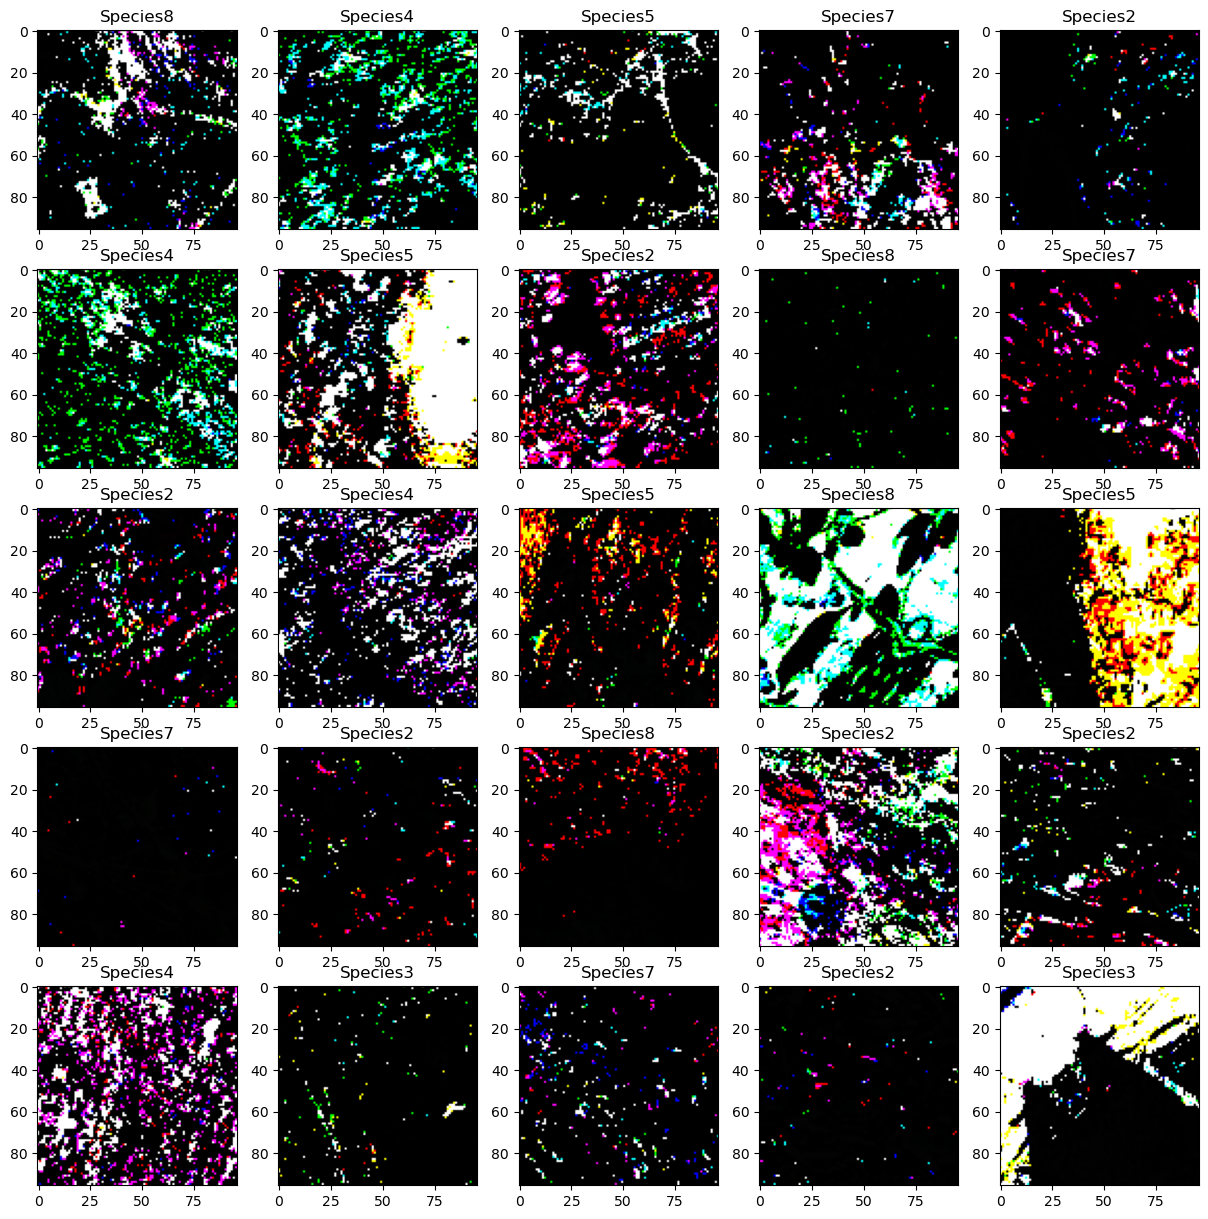

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
for i in range(25):
	# plot raw pixel data
	image = train_dataset.take(1).as_numpy_iterator().next()
	ax[i//5, i%5].imshow(image[0][0])
	ax[i//5, i%5].set_title(labels[np.argmax(image[1][0])])

Classes distributions for weights computation

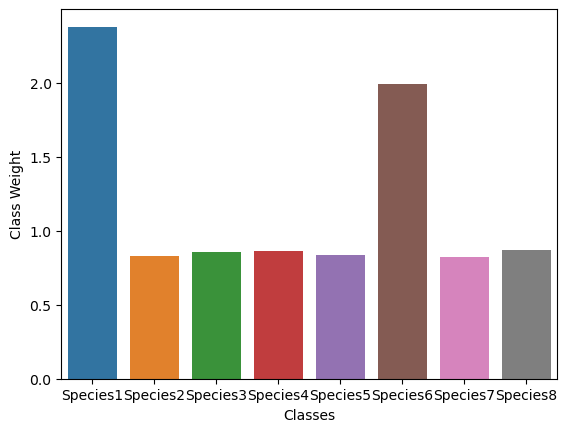

training set input shape (2833, 96, 96, 3) (2833, 8)
validation set input shape (709, 96, 96, 3) (709, 8)


In [8]:
# shows the new classes distribution
y_numeric = []
for v in y:
    y_numeric.append(np.argmax(v))

# computation of the new classes distribution according to a balanced average
class_weights_vect = class_weight.compute_class_weight('balanced', classes=np.arange(8), y=y_numeric)
class_weights = dict(enumerate(class_weights_vect))

# shows the new classes distribution
plt.ylabel('Class Weight')
plt.xlabel('Classes')
sns.barplot(x = labels, y = class_weights_vect)
plt.show()


print(f"training set input shape", X_train.shape, y_train.shape)
print(f"validation set input shape", X_val.shape, y_val.shape)


## Model definition and training

In [9]:
def build_supernet_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.EfficientNetB5(include_top=False,
                                            weights="imagenet",
                                            input_shape=input_shape)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)
    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'super_simonnet_v0')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

All layers of the supernet are trainable

In [10]:
model = build_supernet_model(input_shape)
# Enable the tuning to the whole supernet 
for layer in model.layers:
	layer.trainable = True
	
model.summary()

Model: "conv_dense_model_v1_online"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb5 (Functional)  (None, 3, 3, 2048)       28513527  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 output_layer (Dense)        (None, 8)                 16392     
                                                                 
Total params: 28,529,919
Trainable params: 28,357,176
Non-trainable params: 172,743
_________________________________________________________________


Callbacks for exponential decaying learning rate and the early stopping for regularization

In [11]:
# good GPU utilization on my machine with this batch size
batch_size = 64
epochs = 400

# exponential decay for the learning rate
initial_lr = 1e-3 # suggested 5e-5 for transfer learning applications
def scheduler(epoch, lr):
    if epoch <= 10:
        return initial_lr
    else:
        return max(initial_lr * tf.math.exp(- (epoch-10) / 10.0), 1e-5)
learning_rate_scheduler = tfk.callbacks.LearningRateScheduler(scheduler)

early_stop = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)


# Train the network
history = model.fit(x = train_dataset,
                    epochs = epochs,                                    
                    steps_per_epoch = int(len(X_train)/batch_size),   # 1 epoch will be considered as 1 pass over the training augmented dataset. Thanks to inflation of training set we perform oversampling
                    validation_data = valid_dataset,
                    validation_steps = len(valid_gen),
                    class_weight = class_weights,                       #Class weights not used in the loss function during supernet tuning
                    callbacks = [learning_rate_scheduler, early_stop]
).history

Epoch 1/400
44/44 [==============================] - 90s 1s/step - loss: 1.9464 - accuracy: 0.2827 - val_loss: 1.9578 - val_accuracy: 0.2454 - lr: 5.0000e-04
Epoch 2/400
44/44 [==============================] - 52s 1s/step - loss: 1.7384 - accuracy: 0.3877 - val_loss: 1.9100 - val_accuracy: 0.2793 - lr: 5.0000e-04
Epoch 3/400
44/44 [==============================] - 50s 1s/step - loss: 1.6275 - accuracy: 0.4027 - val_loss: 2.1817 - val_accuracy: 0.2426 - lr: 5.0000e-04
Epoch 4/400
44/44 [==============================] - 51s 1s/step - loss: 1.5875 - accuracy: 0.4458 - val_loss: 2.3314 - val_accuracy: 0.2553 - lr: 5.0000e-04
Epoch 5/400
44/44 [==============================] - 52s 1s/step - loss: 1.4359 - accuracy: 0.4943 - val_loss: 1.9221 - val_accuracy: 0.3639 - lr: 5.0000e-04
Epoch 6/400
44/44 [==============================] - 51s 1s/step - loss: 1.3940 - accuracy: 0.5061 - val_loss: 1.5687 - val_accuracy: 0.4598 - lr: 5.0000e-04
Epoch 7/400
44/44 [==============================] -

KeyboardInterrupt: 

In [ ]:
model.save('supernet_simo_model')

## Model evaluation

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Model statistics evaluation

In [ ]:
predictions = model.predict(valid_dataset,steps=int(len(X_val)/batch_size))
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Second part of model building

In [ ]:
def build_classifier_model(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(include_top=False, input_shape=input_shape)

    # Recover previous weights
    supernet.set_weights(tfk.models.load_model('supernet_simo_model').get_layer('efficientnet').get_weights())
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    x_gap = x

    x = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier2')(x)

    #x = tfkl.Dropout(0.2, seed=seed, name='dropout')(x)

    # Skip connection
    x = tfkl.Add()([x_gap, x])
    
    output_layer = tfkl.Dense(
        units = len(classes), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'super_simonnnet_classifier')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
classifier_model = build_classifier_model(input_shape)

# Use the supernet as a pretrained feature extraction net (and apply eventual fine tuning)
classifier_model.get_layer('efficientnet').trainable = True
for i, layer in enumerate(classifier_model.get_layer('efficientnet').layers[:-5]):
  layer.trainable=False
for i, layer in enumerate(classifier_model.get_layer('efficientnet').layers):
   print(i, layer.name, layer.trainable)  

classifier_model.summary()

In [ ]:
classifier_history = classifier_model.fit(x=train_dataset,
                                          epochs=epochs,                                  
                                          steps_per_epoch=int(len(X_train)/batch_size),
                                          validation_data=valid_dataset,
                                          validation_steps=len(valid_gen),
                                          class_weight=class_weights,
                                          callbacks = [early_stop, learning_rate_scheduler]
).history

In [ ]:
classifier_model.save('super_simo_classifier_model')

## Final Model evaluation

In [ ]:


plt.figure(figsize=(15,5))
plt.plot(classifier_history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(classifier_history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(classifier_history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(classifier_history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
predictions = classifier_model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# Print the confusion matrix using Matplotlib
conf_matrix = confusion_matrix(y_true=np.argmax(y_val, axis=-1), y_pred= np.argmax(predictions, axis=-1))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()